# Installation & Authentication

In [ ]:
!pip install -q -U classiq

In [ ]:
from classiq import authenticate
authenticate()

# Quantum Walk for a General Graph

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from classiq import *
from classiq.execution import ExecutionPreferences
from classiq.qmod.symbolic import logical_or, logical_and
from random import randint
from itertools import product


def sort(counts):
    new_counts = dict(zip([''.join(s) for s in product("01", repeat=size)],
                        [0 for _ in range(2**(size))]))
    for key in sorted(counts):
        new_counts[key] = counts[key]
    return new_counts


@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
    aux ^= (x != 0)


@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute = lambda: prepare_minus(aux), action = lambda: diffuzer_oracle)


def C_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    probabilities = [0.0 for _ in range(graph_size)]
    prob_val = 1 / graph.degree(i)
    for j in graph.neighbors(i):
        probabilities[j] = prob_val

    print(f'State={i}, prob vec ={probabilities}')

    control(ctrl = vertices == i,
            operand = lambda: within_apply(
                compute = lambda: inplace_prepare_state(probabilities=probabilities,
                                                        bound=0.01, target=adjacent_vertices),
                action = lambda: zero_diffuzer(adjacent_vertices)
                )
            )


@qfunc
def C_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(graph_size):
        C_iteration(i, vertices, adjacent_vertices)


@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count=x.len, iteration=lambda i: SWAP(x[i], y[i]))


def check_QNum(cnum: int, qnum: QNum, target: QBit):
    control(ctrl=qnum==cnum,
            operand=lambda:inplace_prepare_state(probabilities=[0, 1], bound=0.01, target=target)
            )


def check_edge(i: int, j: int, vrtx: QNum, adj_vrtx: QNum, target: QArray):
    control(ctrl=vrtx==i,
            operand=lambda:inplace_prepare_state(probabilities=[0, 1], bound=0.01, target=target[0])
            )
    control(ctrl=adj_vrtx==j,
            operand=lambda:inplace_prepare_state(probabilities=[0, 1], bound=0.01, target=target[1])
            )


def S_iterator(i: int, j: int, vertices: QNum, adjacent_vertices: QNum, ctrl: QArray, one_c: QBit):
    check_edge(i, j, vertices, adjacent_vertices, ctrl)
    within_apply(compute=lambda:CCX(ctrl, one_c),
                 action=lambda:control(ctrl=one_c,
                                       operand=lambda:bitwise_swap(vertices, adjacent_vertices)
                                       )
                 )
    inplace_prepare_state(probabilities=[1, 0, 0, 0], bound=0.01, target=ctrl)
    inplace_prepare_state(probabilities=[1, 0], bound=0.01, target=one_c)


@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    ctrl_reg = QArray("ctrl_reg")
    allocate(2, ctrl_reg)
    one_c = QBit(f"bws_c")
    allocate(1, one_c)
    for i, j in graph.edges:
        S_iterator(i, j, vertices, adjacent_vertices, ctrl_reg, one_c)


@qfunc
def main(vertices: Output[QNum],
        #  adjacent_vertices: Output[QNum]
         ):
    allocate(size, vertices)
    hadamard_transform(vertices)
    adjacent_vertices = QNum("adj")
    allocate(size, adjacent_vertices)

    C_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)


def default_synthesis():
    num_shots = 2048
    qmod = create_model(main)
    qmod = set_execution_preferences(qmod,
                execution_preferences=ExecutionPreferences(num_shots=num_shots, OptimizationParameter="depth"),
            )
    qprog = synthesize(qmod)
    show(qprog)
    result = execute(qprog).result()
    counts = sort(result[0].value.counts)

    fig = plt.figure()
    plt.bar(counts.keys(), counts.values())
    plt.xticks(rotation=90)
    plt.show()


# Graph Generator

In [ ]:
def linear_graph(graph_size):
    graph = nx.Graph()
    for i in range(graph_size - 1):
        graph.add_edge(i, i + 1)
    return graph


def cyclic_graph(graph_size):
    graph = nx.Graph()
    for i in range(graph_size):
        graph.add_edge(i, (i + 1) % graph_size)
    return graph


def comb(n, k):
    def fact(n):
        if n in [0, 1]: return 1
        else: return n * fact(n-1)
    return fact(n) // (fact(k) * fact(n-k))


def random_graph(graph_size, edge_num=None):
    from random import randint
    max_edge_num = comb(graph_size, graph_size-2)
    if edge_num is None:
        edge_num = randint(0, max_edge_num-1)
    else:
        assert max_edge_num >= edge_num, f"For the quantum walk problem, the total number of edges of a {node_num}-vertex graph must be less than or equal to {max_edge_num}."
    graph = nx.Graph()
    random_edges = []
    while len(random_edges) < edge_num:
        new_edge = (randint(0, graph_size-1), randint(0, graph_size-1))
        if (new_edge not in random_edges) and (new_edge[::-1] not in random_edges) and (new_edge[0] != new_edge[1]):
            random_edges.append(new_edge)
    graph.add_edges_from(random_edges)
    return graph


# Assignment 6.12

## Linear Graph with 16 Verticies

Following graph is the one given in the assignment 6.12

In [ ]:
size = 4
graph_size = 2 ** size
graph = linear_graph(graph_size)

nx.draw(graph, with_labels=True)

default_synthesis()

### Output

```
ClassiqAPIError: Call to API failed with code 400: Requested program requires too many qubits.
Requested qubits: 29, backend: simulator, limit: 25.
Please run a different program or try a different backend.
```

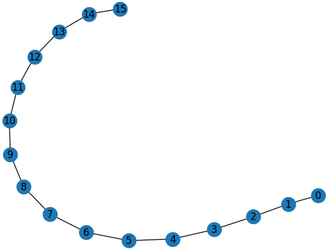

Since I get ClassiqAPIError due to requested qubit number, I'll reduce the total edge number of the graph from 16 to 9, to experiment with my code.

## Linear Graph with 8 Verticies


In [ ]:
size = 3
graph_size = 2 ** size
graph = linear_graph(graph_size)

nx.draw(graph, with_labels=True)

default_synthesis()

### Output

```
State=0, prob vec =[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=1, prob vec =[0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]
State=2, prob vec =[0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0]
State=3, prob vec =[0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0]
State=4, prob vec =[0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0]
State=5, prob vec =[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0]
State=6, prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5]
State=7, prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
```

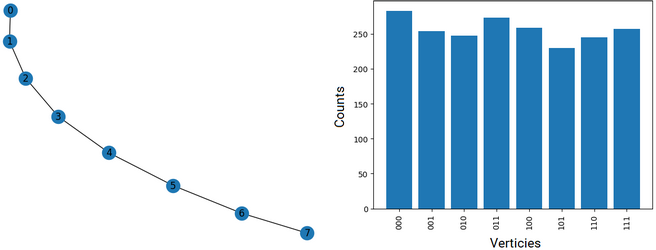

See the last section to understand the bug in the results.

## Linear Graph with 4 Verticies


In [ ]:
size = 2
graph_size = 2 ** size
graph = linear_graph(graph_size)

nx.draw(graph, with_labels=True)

default_synthesis()

### Output

```
State=0, prob vec =[0.0, 1.0, 0.0, 0.0]
State=1, prob vec =[0.5, 0.0, 0.5, 0.0]
State=2, prob vec =[0.0, 0.5, 0.0, 0.5]
State=3, prob vec =[0.0, 0.0, 1.0, 0.0]
```

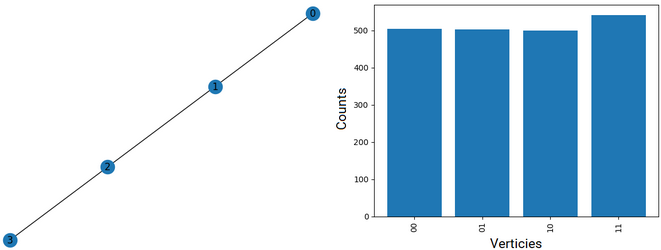

See the last section to understand the bug in the results.

# Random Graph \#1

In [ ]:
size = 2
graph_size = 2 ** size
graph = random_graph(graph_size)
print(f"Quantum Walk with a graph of {len(graph.nodes)} verticies and {len(graph.edges)} edges.")
nx.draw(graph, with_labels=True)

default_synthesis()


## Output

```
Quantum Walk with a graph of 4 verticies and 5 edges.
State=0, prob vec =[0.0, 0.0, 0.5, 0.5]
State=1, prob vec =[0.0, 0.0, 0.5, 0.5]
State=2, prob vec =[0.3333333333333333, 0.3333333333333333, 0.0, 0.3333333333333333]
State=3, prob vec =[0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.0]
```

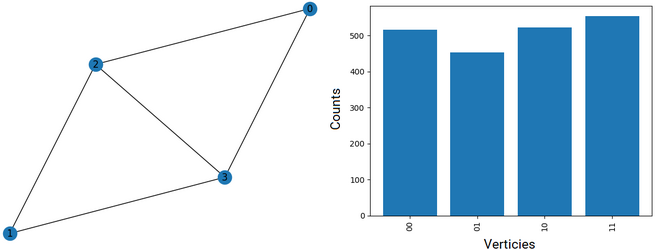

See the last section to understand the bug in the results.

# Random Graph \#2

In [ ]:
size = 3
graph_size = 2 ** size
graph = random_graph(graph_size)
print(f"Quantum Walk with a graph of {len(graph.nodes)} verticies and {len(graph.edges)} edges.")
nx.draw(graph, with_labels=True)

default_synthesis()


## Output

```
Quantum Walk with a graph of 8 verticies and 13 edges.
State=0, prob vec =[0.0, 0.0, 0.3333333333333333, 0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0]
State=1, prob vec =[0.0, 0.0, 0.2, 0.0, 0.2, 0.2, 0.2, 0.2]
State=2, prob vec =[0.25, 0.25, 0.0, 0.25, 0.0, 0.25, 0.0, 0.0]
State=3, prob vec =[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=4, prob vec =[0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0]
State=5, prob vec =[0.2, 0.2, 0.2, 0.0, 0.2, 0.0, 0.0, 0.2]
State=6, prob vec =[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5]
State=7, prob vec =[0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.3333333333333333, 0.3333333333333333, 0.0]
```

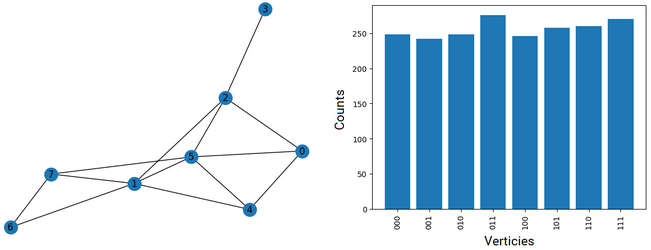

See the last section to understand the bug in the results.

# Issues that needs to be referred

## Error rooted from Graph

For random graphs, dynamic connectivity check should be done. When a random graph includes nodes that has no edges or it is broken two or more connected components, a NetworkXError is thrown during quantum circuit synthesis.

## Bug rooted from QMod

Currently, only quantum number and classical number comparison can be made in QMod language. However, what the S iterator needs for quantum walk in random graphs is that the quantum number can be compared with another quantum number. In order to get rid of the bug caused by this deficiency, a method that can compare the quantum number with the quantum number should be added to the QMod language. Otherwise, it seems quite difficult to implement the quantum walk algorithm with QMod on a random graph.